<a href="https://colab.research.google.com/github/fboldt/aulas-am-bsi/blob/main/aula23b_last_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

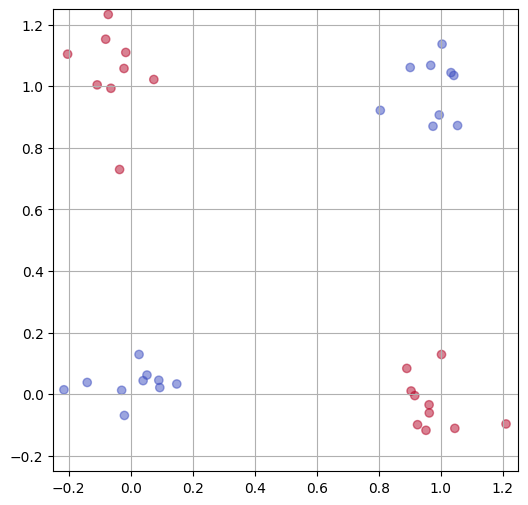

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 40

def generate_logical_dataset(n_samples, func=lambda a, b: bool(a) != bool(b)):
    X, y = make_blobs(n_samples=n_samples,
                      centers=[[0,0],[1,0],[1,1],[0,1]],
                      cluster_std=0.1)
    y = np.array([func(a>0.5, b>0.5) for a, b in zip(X[:,0], X[:,1])], dtype=int) * 2 -1
    return X, y

def plot_dataset(X, y, xlim=(-0.25, 1.25), ylim=(-0.25, 1.25)):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.5, cmap="coolwarm")
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid(True)

def plot_vector(weights):
    xs = [0, weights[0]]
    ys = [0, weights[1]]
    plt.plot(xs, ys, 'g-')

def plot_hyperplane(weights, bias):
    xs = np.array([-11, 11])
    ys = -(weights[0]*xs + bias)/weights[1]
    plt.plot(xs, ys, '--')


X, y = generate_logical_dataset(n_samples)
plot_dataset(X, y)
plt.show()

In [59]:
from abc import ABC, abstractmethod

class CostFunction(ABC):
    @abstractmethod
    def getCost(self, y, ypred):
        pass
    @abstractmethod
    def getGradient(self, X):
        pass

class WidrowHoff(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - ypred
        return 0.5 * np.sum(self.error**2)
    def getGradient(self, X):
        return -X.T @ self.error

In [60]:
from abc import ABC, abstractmethod

class Algorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass


class GradientDescent(Algorithm):
    def __init__(self, max_iter, learning_rate,
                 cost_function=WidrowHoff(),
                 regularization=0):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.cost_function = cost_function
        self.regularization = regularization

    def getW(self, X, y):
        w = np.random.rand(X.shape[1], y.shape[1])
        for _ in range(self.max_iter):
            ypred = X @ w
            cost = self.cost_function.getCost(y, ypred)
            w *= 1 - self.learning_rate * self.regularization
            w -= self.learning_rate * self.cost_function.getGradient(X)
            if cost == 0:
                break
        return w

In [61]:
def define_axes(X):
  offset = 0.5
  min0, max0 = X[:, 0].min(), X[:, 0].max()
  min1, max1 = X[:, 1].min(), X[:, 1].max()
  return [min0-offset, max0+offset], [min1-offset, max1+offset]

def plot_predictions(model, X):
  axis0, axis1 = define_axes(X)
  x0s = np.linspace(axis0[0], axis0[1], 100)
  x1s = np.linspace(axis1[0], axis1[1], 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  X = np.c_[x0.ravel(), x1.ravel()]
  ypred = model.predict(X).reshape(x0.shape)
  plt.contourf(x0, x1, ypred, cmap='coolwarm', alpha=0.2)

1.0


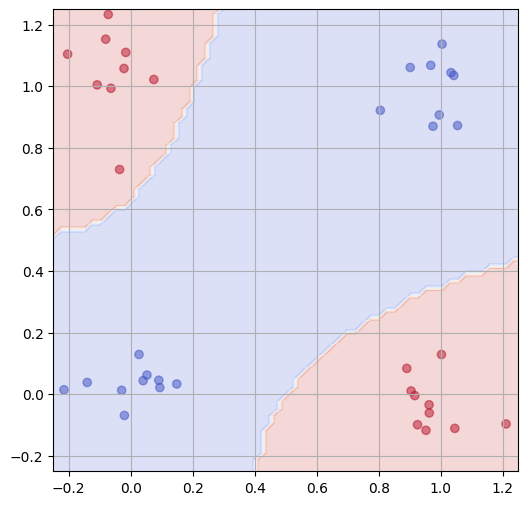

In [114]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  ones = np.ones(shape=(X.shape[0],1))
  return np.hstack((ones, X))

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, algorithm, n_hidden):
    self.algorithm = algorithm
    self.n_hidden = n_hidden

  def fit(self, X, y):
    Xb = include_bias(X)
    self.ihw = np.random.normal(size=(Xb.shape[1], self.n_hidden))
    pH = Xb @ self.ihw
    H = np.tanh(pH)
    Hb = include_bias(H)
    self.how = self.algorithm.getW(Hb, y.reshape(-1,1))
    return self

  def predict(self, X):
    Xb = include_bias(X)
    self.pH = Xb @ self.ihw
    self.H = np.tanh(self.pH)
    Hb = include_bias(self.H)
    ypred = Hb @ self.how
    return np.sign(ypred)

model = NeuralNetwork(GradientDescent(1000, 0.001), 20)
model.fit(X, y)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_predictions(model, X)
plt.show()